In [1]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [10]:
full_data = pd.read_csv("data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

full_labels = pd.read_csv("data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



ERROR! Session/line number was not unique in database. History logging moved to new session 3217


In [11]:
# log R0 sample rate and migration rate
full_labels[:,5:8] = np.log(full_labels[:,5:8])

In [12]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]

In [13]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 5000  # found early stoping epoch number using 10000 validation
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [14]:
# normalize labels
labels = full_labels[0:num_sample,5:8]
norm_train_labels, train_label_means, train_label_sd = cn.normalize(labels[(num_test + num_validation):,:])
norm_validation_labels = cn.normalize(labels[num_test:num_test + num_validation,], (train_label_means, train_label_sd))
norm_test_labels = cn.normalize(labels[:num_test,], (train_label_means, train_label_sd))


In [15]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,8], 
                                  full_labels[0:num_sample,9])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [16]:
# dev create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)


(105157, 499, 7) (105157, 5, 2)
(5000, 499, 7) (5000, 5, 2)
(1000, 499, 7) (1000, 5, 2)


In [20]:
train_treeLocation_tensor[1,0:200,2:7]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0.

In [18]:
#scramble order of locations
old = train_treeLocation_tensor.copy()
print(train_treeLocation_tensor[0:4,0:3,:])

for i in range(0, train_treeLocation_tensor.shape[0]):
    #print(i)
    randomized_idx = np.random.permutation(num_tips[i])
    train_treeLocation_tensor[i,0:num_tips[i],2:7] = train_treeLocation_tensor[i,randomized_idx,2:7]
    
    
print("oooooooooooooooooooooooooooooooo")
print(train_treeLocation_tensor[0:4,0:3,:])

[[[0.         5.6388238  0.         0.         1.         0.
   0.        ]
  [3.19726261 2.44156119 0.         1.         0.         0.
   0.        ]
  [3.51661325 2.12221055 0.         0.         0.         0.
   1.        ]]

 [[0.         7.24107652 1.         0.         0.         0.
   0.        ]
  [7.02877904 0.21229748 1.         0.         0.         0.
   0.        ]
  [5.04040422 1.50672987 1.         0.         0.         0.
   0.        ]]

 [[0.         5.9405297  0.         0.         0.         0.
   1.        ]
  [4.07680942 1.86372029 0.         0.         0.         0.
   1.        ]
  [4.84631904 1.09421066 0.         0.         0.         0.
   1.        ]]

 [[0.         7.39201681 0.         0.         0.         0.
   1.        ]
  [5.20594699 2.16576338 0.         0.         0.         0.
   1.        ]
  [3.52225226 3.86976455 0.         0.         0.         0.
   1.        ]]]
oooooooooooooooooooooooooooooooo
[[[0.         5.6388238  0.         1.         

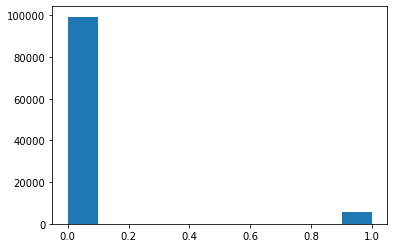

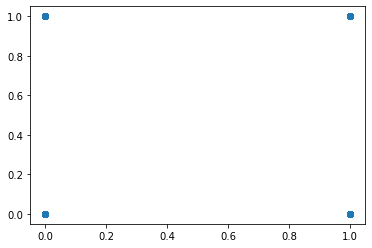

20900.0
14883.0
4761.0
5844.0
6017.0
69.0


In [21]:
plt.hist(train_treeLocation_tensor[:,490,6])
plt.show()
plt.scatter(train_treeLocation_tensor[:,0,2], old[:,0,2])
plt.show()
print(np.sum(old[:,10,2]))
print(np.sum(train_treeLocation_tensor[:,10,2]))
print(np.sum(old[:,490,3]))
print(np.sum(train_treeLocation_tensor[:,490,3]))
print(np.sum(old[:,10,2] - train_treeLocation_tensor[:,10,2]))
print(np.sum(train_treeLocation_tensor[1000,:,6]))

In [12]:
im.reload(cn)


<module 'cnn_utilities' from 'C:\\Users\\ammon_work\\Desktop\\git_repos\\epi_geo_simulation\\neural_network_dev\\cnn_utilities.py'>

In [63]:
# multi input cnn
input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
#w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

# tree + geolocation dilated
w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

# prior known parameters and data statistics
input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
priors = layers.Flatten()(input_priors_tensor)
priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

# concatenate all above -> deep fully connected network
concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                             w_global_avg,
                                                                             w_dilated_global_avg,
                                                                             priors])

wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)
wxyz = layers.Dense(128, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)

output_R0_sampleRate_migrationRate = layers.Dense(3, activation = 'linear', name = "R0_delta_m_output")(wxyz)




In [64]:
# make CNN architecture plot
# import pydot
# from keras.utils.vis_utils import plot_model

# plot_model(Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
#                 outputs = output_R0_sampleRate_migrationRate), to_file='saved_models/model_plot_R0_sampleRate_migrationRate.png', 
#            show_shapes=True, show_layer_names=False, expand_nested = True, dpi = 500)

Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 380s 4ms/step - loss: 0.3306 - mae: 0.3904 - acc: 0.7132 - mape: 170.1299 - val_loss: 0.1222 - val_mae: 0.2493 - val_acc: 0.8080 - val_mape: 136.4374
Epoch 2/15
105157/105157 [==============================] - 212s 2ms/step - loss: 0.1465 - mae: 0.2679 - acc: 0.7922 - mape: 153.8166 - val_loss: 0.1109 - val_mae: 0.2380 - val_acc: 0.8090 - val_mape: 131.6333
Epoch 3/15
105157/105157 [==============================] - 214s 2ms/step - loss: 0.1314 - mae: 0.2521 - acc: 0.8034 - mape: 145.2575 - val_loss: 0.1022 - val_mae: 0.2223 - val_acc: 0.8252 - val_mape: 123.0600
Epoch 4/15
105157/105157 [==============================] - 214s 2ms/step - loss: 0.1219 - mae: 0.2424 - acc: 0.8095 - mape: 140.3027 - val_loss: 0.1033 - val_mae: 0.2314 - val_acc: 0.8144 - val_mape: 138.0457
Epoch 5/15
105157/105157 [==============================] - 214s 2ms/step - loss: 0.1147 - mae: 0.2354 - acc: 

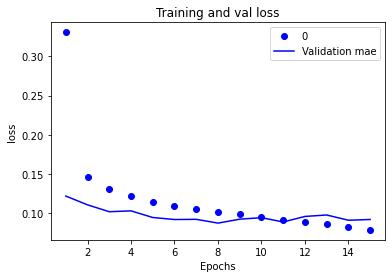

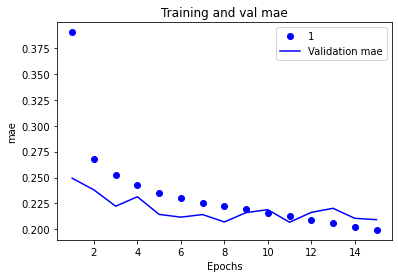

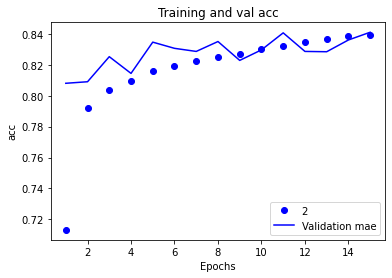

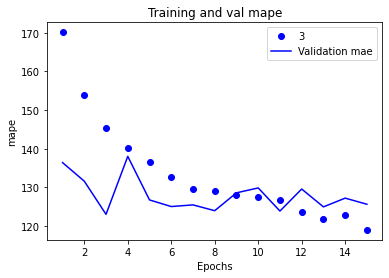

In [65]:
my_loss = "mse"

# instantiate MODEL
mymodel = Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = output_R0_sampleRate_migrationRate)
mymodel.compile(optimizer = 'adam', 
                loss = my_loss, 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel.fit([train_treeLocation_tensor, train_prior_tensor], 
                      norm_train_labels,
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       norm_validation_labels))



# make history plots
cn.make_history_plot(history)


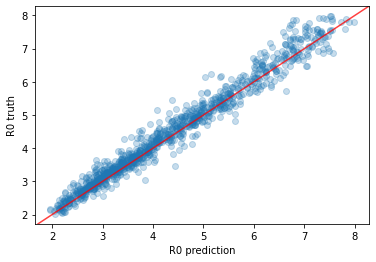

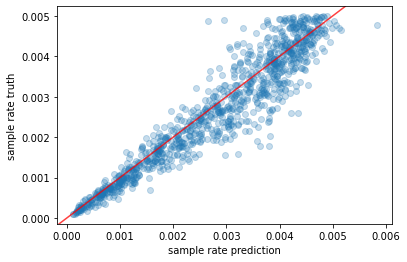

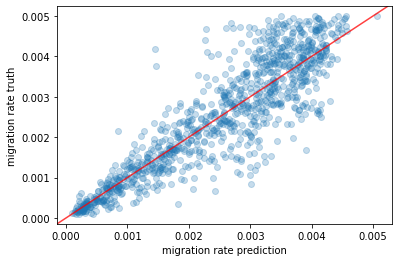

In [66]:
# training data plots

normalized_train_preds = mymodel.predict([train_treeLocation_tensor[0:1000,:,:], 
                                          train_prior_tensor[0:1000,:,:]])

# reverse normalization
denormalized_train_labels = cn.denormalize(norm_train_labels[0:1000,:], train_label_means, train_label_sd)
denormalized_train_labels = np.exp(denormalized_train_labels)
train_preds = cn.denormalize(normalized_train_preds, train_label_means, train_label_sd)
train_preds = np.exp(train_preds)

# make scatter plots
cn.plot_preds_labels(train_preds, denormalized_train_labels, 
                     param_names = ["R0", "sample rate", "migration rate"])


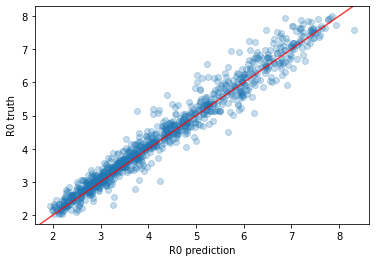

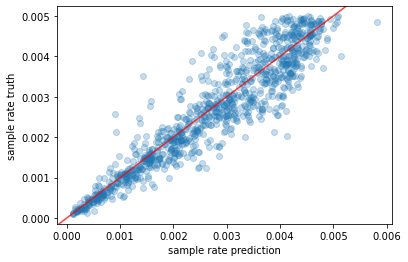

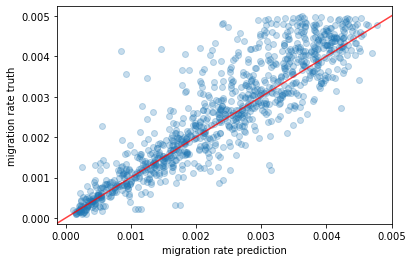

In [67]:
# validation data plots

normalized_val_preds = mymodel.predict([validation_treeLocation_tensor[0:1000,:,:], 
                                          validation_prior_tensor[0:1000,:,:]])

# reverse normalization
denormalized_val_labels = cn.denormalize(norm_validation_labels[0:1000,:], train_label_means, train_label_sd)
denormalized_val_labels = np.exp(denormalized_val_labels)
val_preds = cn.denormalize(normalized_val_preds, train_label_means, train_label_sd)
val_preds = np.exp(val_preds)

# make scatter plots
cn.plot_preds_labels(val_preds, denormalized_val_labels, 
                     param_names = ["R0", "sample rate", "migration rate"])


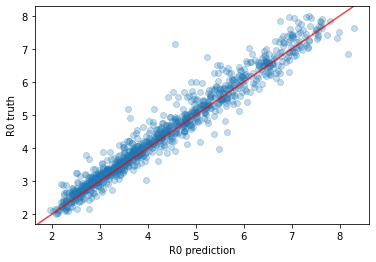

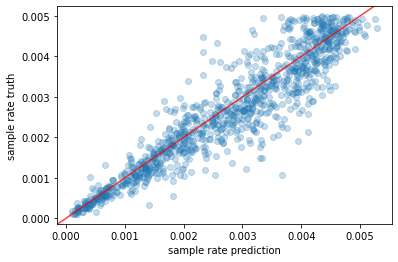

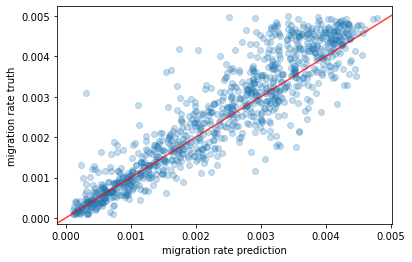

1000/1000 [==============================] - 1s 1ms/step


[0.0920089241862297,
 0.20703256130218506,
 0.8389999866485596,
 113.00115966796875]

In [68]:
# test data plots

normalized_test_preds = mymodel.predict([test_treeLocation_tensor, test_prior_tensor])

# reversing normalization
denormalized_test_labels = cn.denormalize(norm_test_labels, train_label_means, train_label_sd)
denormalized_test_labels = np.exp(denormalized_test_labels)
test_preds = cn.denormalize(normalized_test_preds, train_label_means, train_label_sd)
test_preds = np.exp(test_preds)

# summarize results
cn.plot_preds_labels(test_preds[0:1000,:], denormalized_test_labels[0:1000,:], 
                     param_names = ["R0", "sample rate", "migration rate"])


mymodel.evaluate([test_treeLocation_tensor, test_prior_tensor], norm_test_labels)


In [38]:
# SAVE MODEL to FILE
import csv
all_means = np.append(train_label_means, train_aux_priors_means)
all_sd = np.append(train_label_sd, train_aux_priors_sd)
with open('saved_models/train_extant_normalization_label_mean_sd.csv', 'w') as file:
    the_writer = csv.writer(file)
    the_writer.writerow(["mean_sd","R0","log_sample_rate", "log_migration_rate", 
                                "mu", "subsample_proportion", "num_tips",
                                "tmrca", "mean_bl"])
    
    the_writer.writerow(np.append("mean", all_means))
    the_writer.writerow(np.append("sd", all_sd))

mymodel.save("saved_models/train_extant_R0_sampleRate_migrationRate.hdf5")


In [28]:
bob = [train_treeLocation_tensor[1,:,2], old[1,:,2]]

ERROR! Session/line number was not unique in database. History logging moved to new session 3218


In [52]:
bob = [train_treeLocation_tensor[1000,:,6], old[1000,:,6]]
print((bob[0][0:num_tips[1000]] - bob[1][0:num_tips[1000]])**2)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.